# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

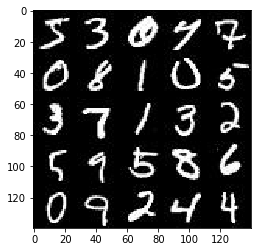

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

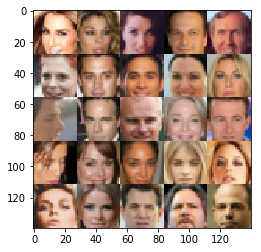

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Functio
    real_input = tf.placeholder(tf.float32, shape=[None, image_height, image_height, image_channels], name='real_input')
    z_data = tf.placeholder(tf.float32, shape=[None, z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return real_input, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input is an image: 28x28x3(or 1)
        c1 = tf.layers.conv2d(images, 64, [5,5], [2,2], activation=None, padding='same')
        c1 = tf.maximum(0.2*c1, c1)
        
        # Input is 14x14x64
        c2 = tf.layers.conv2d(c1, 128, [5,5], [2,2], activation=None, padding='same')
        c2 = tf.layers.batch_normalization(c2, training=True)
        c2 = tf.maximum(0.2*c2, c2)
        
        # Input is 7x7x128
        c3 = tf.layers.conv2d(c2, 256, [5,5], [2,2], activation=None, padding='same')
        c3 = tf.layers.batch_normalization(c3, training=True)
        c3 = tf.maximum(0.2*c3, c3)
        
        # Input is 4x4x256
        c3_flat = tf.reshape(c3, [-1, 4*4*256])
        logits = tf.layers.dense(c3_flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First layer is fully connected.
        layer_size = 7*7*512
        x = tf.layers.dense(inputs=z, units=layer_size)

        # Reshape into a convolutional layer.
        c1 = tf.reshape(x, [-1, 7, 7, 512])
        c1 = tf.layers.batch_normalization(c1, training=is_train)
        c1 = tf.maximum(0.2*c1, c1)
        
        # Input is 7x7x512
        c2 = tf.layers.conv2d_transpose(c1, 256, 5, [2,2], activation=None, padding='same')
        c2 = tf.layers.batch_normalization(c2, training=is_train)
        c2 = tf.maximum(0.2*c2, c2)
        
        # Input is 14x14x256
        c3 = tf.layers.conv2d_transpose(c2, 128, 5, [2,2], activation=None, padding='same')
        c3 = tf.layers.batch_normalization(c3, training=is_train)
        c3 = tf.maximum(0.2*c3, c3)
        
        # Convert to 28x28x256 to 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(c3, out_channel_dim, 5, [1,1], activation=None, padding='same')
        
        # Discriminator excepts -1 to 1 -> apply tanh
        output = tf.tanh(logits)
    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    d_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_real_loss + d_fake_loss
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Get weights and bias to update.
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, freq_see_loss = 10):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # Get the out_channel_dim.
    if data_image_mode == "RGB":
        out_channel_dim = 3
    elif data_image_mode == "L":
        out_channel_dim = 1
        
    # Get the image dimensions.
    image_width = data_shape[-2]
    image_height = data_shape[-3]
        
    # Get the model inputs.
    real_input, z_data, learning_rate_placeholder = model_inputs(image_width, image_height, out_channel_dim, z_dim)
    
    # Obtain the losses.
    d_loss, g_loss = model_loss(real_input, z_data, out_channel_dim)
    
    # Obtain the model optimization operations.
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Container to hold the losses.
    g_losses = []
    d_losses = []
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps+=1
                
                # Generate the random z vector.
#                 z_data_input = tf.random_uniform([batch_size, z_dim], -1, 1)
                z_data_input = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_train_opt, feed_dict={real_input:batch_images, z_data:z_data_input})
                sess.run(g_train_opt, feed_dict={real_input:batch_images, z_data:z_data_input})
                
                if steps % freq_see_loss == 0:
                    d_loss_out, g_loss_out = sess.run([d_loss, g_loss], feed_dict={real_input:batch_images, z_data:z_data_input})
                    
                    print('Epoch: {} -- Step: {} -- d_loss: {} -- g_loss: {}'.format(epoch_i, steps, d_loss_out, g_loss_out))
                    g_losses.append(g_loss_out)
                    d_losses.append(d_loss_out)
                
                if steps % 100 == 0:
                    z_data_input_tensor = tf.random_uniform([16, z_dim], -1, 1)
                    show_generator_output(sess, 16, z_data_input_tensor, out_channel_dim, data_image_mode)
                    
    plt.figure()
    plt.plot(g_losses)
    plt.title('g_losses')
    plt.figure()
    plt.plot(d_losses)
    plt.title('d_losses')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 0 -- Step: 10 -- d_loss: 0.06874499469995499 -- g_loss: 3.4679577350616455
Epoch: 0 -- Step: 20 -- d_loss: 0.1225709617137909 -- g_loss: 5.267463207244873
Epoch: 0 -- Step: 30 -- d_loss: 0.5474578738212585 -- g_loss: 1.2861260175704956
Epoch: 0 -- Step: 40 -- d_loss: 0.06011590361595154 -- g_loss: 3.6188244819641113
Epoch: 0 -- Step: 50 -- d_loss: 2.374044895172119 -- g_loss: 0.2207002192735672
Epoch: 0 -- Step: 60 -- d_loss: 0.6943635940551758 -- g_loss: 1.4357280731201172
Epoch: 0 -- Step: 70 -- d_loss: 0.9561102986335754 -- g_loss: 1.1545813083648682
Epoch: 0 -- Step: 80 -- d_loss: 0.6855154633522034 -- g_loss: 2.7046194076538086
Epoch: 0 -- Step: 90 -- d_loss: 0.5309109091758728 -- g_loss: 1.7293187379837036
Epoch: 0 -- Step: 100 -- d_loss: 0.559805691242218 -- g_loss: 2.4114060401916504


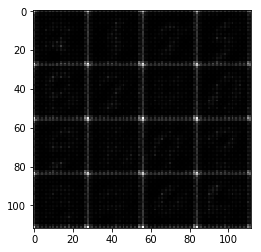

Epoch: 0 -- Step: 110 -- d_loss: 0.38125598430633545 -- g_loss: 1.9197547435760498
Epoch: 0 -- Step: 120 -- d_loss: 0.33766883611679077 -- g_loss: 1.6350023746490479
Epoch: 0 -- Step: 130 -- d_loss: 0.25797781348228455 -- g_loss: 3.5532917976379395
Epoch: 0 -- Step: 140 -- d_loss: 0.1465613842010498 -- g_loss: 2.962038040161133
Epoch: 0 -- Step: 150 -- d_loss: 0.1270531415939331 -- g_loss: 2.7946295738220215
Epoch: 0 -- Step: 160 -- d_loss: 0.10824921727180481 -- g_loss: 2.790494441986084
Epoch: 0 -- Step: 170 -- d_loss: 0.05979820340871811 -- g_loss: 3.4838595390319824
Epoch: 0 -- Step: 180 -- d_loss: 0.06982716917991638 -- g_loss: 3.6087121963500977
Epoch: 0 -- Step: 190 -- d_loss: 0.026008863002061844 -- g_loss: 4.270388603210449
Epoch: 0 -- Step: 200 -- d_loss: 0.06112693250179291 -- g_loss: 3.532315731048584


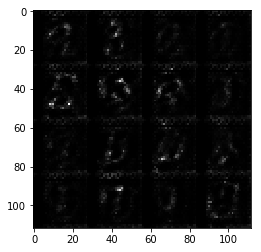

Epoch: 0 -- Step: 210 -- d_loss: 0.06289277225732803 -- g_loss: 3.353271007537842
Epoch: 0 -- Step: 220 -- d_loss: 0.04941532760858536 -- g_loss: 3.5855698585510254
Epoch: 0 -- Step: 230 -- d_loss: 0.03143318369984627 -- g_loss: 3.7143120765686035
Epoch: 0 -- Step: 240 -- d_loss: 0.016009949147701263 -- g_loss: 4.725394248962402
Epoch: 0 -- Step: 250 -- d_loss: 0.027458272874355316 -- g_loss: 4.109528541564941
Epoch: 0 -- Step: 260 -- d_loss: 0.028032829985022545 -- g_loss: 4.782452583312988
Epoch: 0 -- Step: 270 -- d_loss: 0.01465727761387825 -- g_loss: 5.077298164367676
Epoch: 0 -- Step: 280 -- d_loss: 0.020089730620384216 -- g_loss: 4.9445390701293945
Epoch: 0 -- Step: 290 -- d_loss: 0.020185410976409912 -- g_loss: 5.020179271697998
Epoch: 0 -- Step: 300 -- d_loss: 0.04392344504594803 -- g_loss: 3.7260446548461914


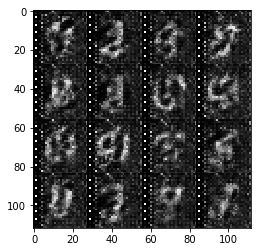

Epoch: 0 -- Step: 310 -- d_loss: 0.06260931491851807 -- g_loss: 7.147215843200684
Epoch: 0 -- Step: 320 -- d_loss: 0.01026644092053175 -- g_loss: 6.386506080627441
Epoch: 0 -- Step: 330 -- d_loss: 1.9194585084915161 -- g_loss: 8.206267356872559
Epoch: 0 -- Step: 340 -- d_loss: 0.2250586897134781 -- g_loss: 4.396332740783691
Epoch: 0 -- Step: 350 -- d_loss: 0.12160851806402206 -- g_loss: 3.1271438598632812
Epoch: 0 -- Step: 360 -- d_loss: 0.10694905370473862 -- g_loss: 3.342301607131958
Epoch: 0 -- Step: 370 -- d_loss: 0.0665164515376091 -- g_loss: 5.632979869842529
Epoch: 0 -- Step: 380 -- d_loss: 0.6590400338172913 -- g_loss: 4.752902984619141
Epoch: 0 -- Step: 390 -- d_loss: 0.24676910042762756 -- g_loss: 2.305494785308838
Epoch: 0 -- Step: 400 -- d_loss: 0.12069693952798843 -- g_loss: 5.094542503356934


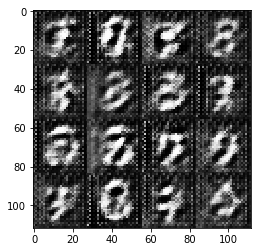

Epoch: 0 -- Step: 410 -- d_loss: 0.16405877470970154 -- g_loss: 3.6525344848632812
Epoch: 0 -- Step: 420 -- d_loss: 0.20916801691055298 -- g_loss: 3.347369432449341
Epoch: 0 -- Step: 430 -- d_loss: 0.0809243842959404 -- g_loss: 7.691722869873047
Epoch: 0 -- Step: 440 -- d_loss: 0.09303902834653854 -- g_loss: 4.697911262512207
Epoch: 0 -- Step: 450 -- d_loss: 0.03502565622329712 -- g_loss: 8.533926010131836
Epoch: 0 -- Step: 460 -- d_loss: 0.05940888077020645 -- g_loss: 4.977114677429199
Epoch: 1 -- Step: 470 -- d_loss: 0.1969318389892578 -- g_loss: 3.397766351699829
Epoch: 1 -- Step: 480 -- d_loss: 0.0545564629137516 -- g_loss: 3.9232685565948486
Epoch: 1 -- Step: 490 -- d_loss: 0.10218200087547302 -- g_loss: 3.7359416484832764
Epoch: 1 -- Step: 500 -- d_loss: 0.0697968453168869 -- g_loss: 4.821435928344727


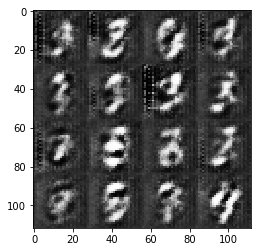

Epoch: 1 -- Step: 510 -- d_loss: 0.03949593007564545 -- g_loss: 9.184005737304688
Epoch: 1 -- Step: 520 -- d_loss: 0.013397776521742344 -- g_loss: 7.0203776359558105
Epoch: 1 -- Step: 530 -- d_loss: 0.06756200641393661 -- g_loss: 9.385318756103516
Epoch: 1 -- Step: 540 -- d_loss: 0.13190239667892456 -- g_loss: 4.597324371337891
Epoch: 1 -- Step: 550 -- d_loss: 0.17603984475135803 -- g_loss: 2.6819167137145996
Epoch: 1 -- Step: 560 -- d_loss: 0.06596237421035767 -- g_loss: 8.41409683227539
Epoch: 1 -- Step: 570 -- d_loss: 0.04551804065704346 -- g_loss: 13.17457389831543
Epoch: 1 -- Step: 580 -- d_loss: 0.07616374641656876 -- g_loss: 3.549196720123291
Epoch: 1 -- Step: 590 -- d_loss: 0.21461351215839386 -- g_loss: 8.182296752929688
Epoch: 1 -- Step: 600 -- d_loss: 0.05153846740722656 -- g_loss: 4.735297203063965


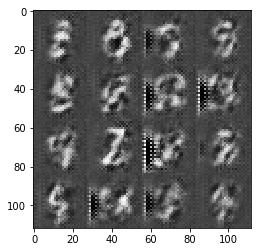

Epoch: 1 -- Step: 610 -- d_loss: 0.27684736251831055 -- g_loss: 2.0952627658843994
Epoch: 1 -- Step: 620 -- d_loss: 0.03919314965605736 -- g_loss: 6.143050670623779
Epoch: 1 -- Step: 630 -- d_loss: 0.20115458965301514 -- g_loss: 9.551822662353516
Epoch: 1 -- Step: 640 -- d_loss: 0.11787354946136475 -- g_loss: 3.7745370864868164
Epoch: 1 -- Step: 650 -- d_loss: 0.025348283350467682 -- g_loss: 6.677721977233887
Epoch: 1 -- Step: 660 -- d_loss: 0.28363412618637085 -- g_loss: 2.1755423545837402
Epoch: 1 -- Step: 670 -- d_loss: 0.04074126109480858 -- g_loss: 7.908172607421875
Epoch: 1 -- Step: 680 -- d_loss: 0.01563926413655281 -- g_loss: 6.974915504455566
Epoch: 1 -- Step: 690 -- d_loss: 1.402616024017334 -- g_loss: 0.7556881308555603
Epoch: 1 -- Step: 700 -- d_loss: 0.10949273407459259 -- g_loss: 6.568037986755371


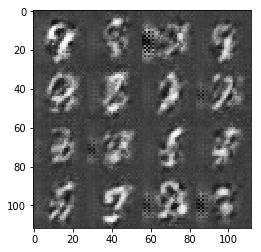

Epoch: 1 -- Step: 710 -- d_loss: 0.04581848531961441 -- g_loss: 5.938446998596191
Epoch: 1 -- Step: 720 -- d_loss: 0.0952296257019043 -- g_loss: 6.681878566741943
Epoch: 1 -- Step: 730 -- d_loss: 0.02080462872982025 -- g_loss: 5.487847328186035
Epoch: 1 -- Step: 740 -- d_loss: 0.05455808341503143 -- g_loss: 3.5042901039123535
Epoch: 1 -- Step: 750 -- d_loss: 1.8832887411117554 -- g_loss: 0.2898317277431488
Epoch: 1 -- Step: 760 -- d_loss: 1.0979671478271484 -- g_loss: 1.1694433689117432
Epoch: 1 -- Step: 770 -- d_loss: 0.7585985064506531 -- g_loss: 2.421330451965332
Epoch: 1 -- Step: 780 -- d_loss: 0.26909902691841125 -- g_loss: 2.119476795196533
Epoch: 1 -- Step: 790 -- d_loss: 0.31016531586647034 -- g_loss: 1.980636477470398
Epoch: 1 -- Step: 800 -- d_loss: 0.23398442566394806 -- g_loss: 1.9546937942504883


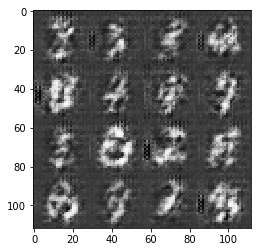

Epoch: 1 -- Step: 810 -- d_loss: 0.1360062211751938 -- g_loss: 3.6920313835144043
Epoch: 1 -- Step: 820 -- d_loss: 0.37729012966156006 -- g_loss: 1.5091664791107178
Epoch: 1 -- Step: 830 -- d_loss: 0.03523929789662361 -- g_loss: 6.259937763214111
Epoch: 1 -- Step: 840 -- d_loss: 0.028420574963092804 -- g_loss: 5.219725608825684
Epoch: 1 -- Step: 850 -- d_loss: 0.04839734360575676 -- g_loss: 4.260593891143799
Epoch: 1 -- Step: 860 -- d_loss: 0.11251486837863922 -- g_loss: 2.7584524154663086
Epoch: 1 -- Step: 870 -- d_loss: 0.019215045496821404 -- g_loss: 9.753602027893066
Epoch: 1 -- Step: 880 -- d_loss: 2.968489170074463 -- g_loss: 0.12015162408351898
Epoch: 1 -- Step: 890 -- d_loss: 0.7486714124679565 -- g_loss: 1.170501947402954
Epoch: 1 -- Step: 900 -- d_loss: 0.7553533315658569 -- g_loss: 0.7685103416442871


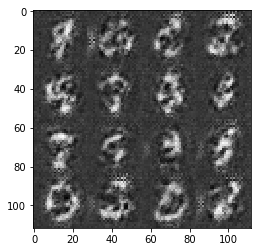

Epoch: 1 -- Step: 910 -- d_loss: 0.4452810287475586 -- g_loss: 1.3613815307617188
Epoch: 1 -- Step: 920 -- d_loss: 0.2865251898765564 -- g_loss: 2.6713125705718994
Epoch: 1 -- Step: 930 -- d_loss: 0.06353162229061127 -- g_loss: 3.564767360687256


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 0 -- Step: 10 -- d_loss: 1.3393371105194092 -- g_loss: 0.5507873892784119
Epoch: 0 -- Step: 20 -- d_loss: 0.5014923810958862 -- g_loss: 1.6089727878570557
Epoch: 0 -- Step: 30 -- d_loss: 0.34719014167785645 -- g_loss: 3.591370105743408
Epoch: 0 -- Step: 40 -- d_loss: 0.5834575891494751 -- g_loss: 5.691573143005371
Epoch: 0 -- Step: 50 -- d_loss: 0.5739845633506775 -- g_loss: 1.2918182611465454
Epoch: 0 -- Step: 60 -- d_loss: 0.2353624701499939 -- g_loss: 2.4340202808380127
Epoch: 0 -- Step: 70 -- d_loss: 0.19732555747032166 -- g_loss: 3.098560333251953
Epoch: 0 -- Step: 80 -- d_loss: 0.1581384688615799 -- g_loss: 2.372143030166626
Epoch: 0 -- Step: 90 -- d_loss: 0.05921667069196701 -- g_loss: 3.987537384033203
Epoch: 0 -- Step: 100 -- d_loss: 0.07629264891147614 -- g_loss: 2.9815266132354736


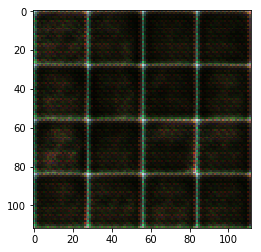

Epoch: 0 -- Step: 110 -- d_loss: 0.04978560656309128 -- g_loss: 6.541148662567139
Epoch: 0 -- Step: 120 -- d_loss: 0.023744918406009674 -- g_loss: 4.210055828094482
Epoch: 0 -- Step: 130 -- d_loss: 0.14366033673286438 -- g_loss: 2.3907957077026367
Epoch: 0 -- Step: 140 -- d_loss: 0.02655552700161934 -- g_loss: 4.396571159362793
Epoch: 0 -- Step: 150 -- d_loss: 0.021555842831730843 -- g_loss: 7.423258304595947
Epoch: 0 -- Step: 160 -- d_loss: 0.03401751443743706 -- g_loss: 3.932480812072754
Epoch: 0 -- Step: 170 -- d_loss: 0.021113160997629166 -- g_loss: 4.69598913192749
Epoch: 0 -- Step: 180 -- d_loss: 0.0544581338763237 -- g_loss: 3.332357883453369
Epoch: 0 -- Step: 190 -- d_loss: 0.04980088770389557 -- g_loss: 3.8791842460632324
Epoch: 0 -- Step: 200 -- d_loss: 0.0495820976793766 -- g_loss: 3.359964609146118


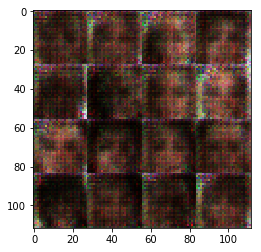

Epoch: 0 -- Step: 210 -- d_loss: 0.032247111201286316 -- g_loss: 4.176661014556885
Epoch: 0 -- Step: 220 -- d_loss: 0.10365407913923264 -- g_loss: 2.974555492401123
Epoch: 0 -- Step: 230 -- d_loss: 0.907044529914856 -- g_loss: 11.531270027160645
Epoch: 0 -- Step: 240 -- d_loss: 0.14768414199352264 -- g_loss: 7.287369251251221
Epoch: 0 -- Step: 250 -- d_loss: 0.09373226761817932 -- g_loss: 3.3799474239349365
Epoch: 0 -- Step: 260 -- d_loss: 0.013667336665093899 -- g_loss: 6.319916248321533
Epoch: 0 -- Step: 270 -- d_loss: 0.0372328981757164 -- g_loss: 6.356014251708984
Epoch: 0 -- Step: 280 -- d_loss: 0.48471012711524963 -- g_loss: 2.5152316093444824
Epoch: 0 -- Step: 290 -- d_loss: 0.20228995382785797 -- g_loss: 3.888152837753296
Epoch: 0 -- Step: 300 -- d_loss: 0.8082070350646973 -- g_loss: 1.3315399885177612


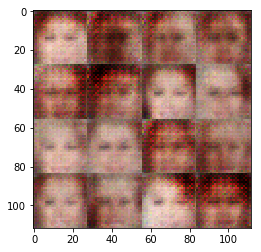

Epoch: 0 -- Step: 310 -- d_loss: 0.1481483280658722 -- g_loss: 10.086941719055176
Epoch: 0 -- Step: 320 -- d_loss: 0.4639136791229248 -- g_loss: 1.2826979160308838
Epoch: 0 -- Step: 330 -- d_loss: 0.2668571174144745 -- g_loss: 2.474315643310547
Epoch: 0 -- Step: 340 -- d_loss: 0.5622149705886841 -- g_loss: 3.129366636276245
Epoch: 0 -- Step: 350 -- d_loss: 0.37653622031211853 -- g_loss: 1.442258596420288
Epoch: 0 -- Step: 360 -- d_loss: 0.7671666145324707 -- g_loss: 2.6361448764801025
Epoch: 0 -- Step: 370 -- d_loss: 0.2790437340736389 -- g_loss: 1.6916890144348145
Epoch: 0 -- Step: 380 -- d_loss: 0.05444975569844246 -- g_loss: 9.15966510772705
Epoch: 0 -- Step: 390 -- d_loss: 0.06597380340099335 -- g_loss: 4.272350788116455
Epoch: 0 -- Step: 400 -- d_loss: 0.23978252708911896 -- g_loss: 1.9154047966003418


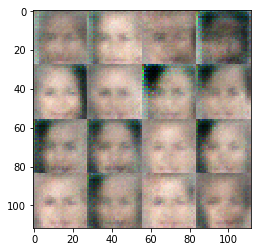

Epoch: 0 -- Step: 410 -- d_loss: 0.023583106696605682 -- g_loss: 5.911017894744873
Epoch: 0 -- Step: 420 -- d_loss: 0.6042789816856384 -- g_loss: 1.1850730180740356
Epoch: 0 -- Step: 430 -- d_loss: 0.07912513613700867 -- g_loss: 3.1424882411956787
Epoch: 0 -- Step: 440 -- d_loss: 0.2926252484321594 -- g_loss: 2.228233814239502
Epoch: 0 -- Step: 450 -- d_loss: 0.32349541783332825 -- g_loss: 2.6278529167175293
Epoch: 0 -- Step: 460 -- d_loss: 0.1709587574005127 -- g_loss: 2.513777256011963
Epoch: 0 -- Step: 470 -- d_loss: 0.04816490411758423 -- g_loss: 4.280249118804932
Epoch: 0 -- Step: 480 -- d_loss: 0.09353920817375183 -- g_loss: 3.29101824760437
Epoch: 0 -- Step: 490 -- d_loss: 0.06746640056371689 -- g_loss: 3.2132744789123535
Epoch: 0 -- Step: 500 -- d_loss: 0.16624870896339417 -- g_loss: 2.419748544692993


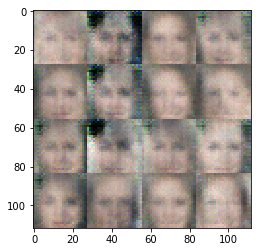

Epoch: 0 -- Step: 510 -- d_loss: 2.650343894958496 -- g_loss: 0.13045890629291534
Epoch: 0 -- Step: 520 -- d_loss: 0.7206774353981018 -- g_loss: 1.4577511548995972
Epoch: 0 -- Step: 530 -- d_loss: 0.2864140570163727 -- g_loss: 3.4984447956085205
Epoch: 0 -- Step: 540 -- d_loss: 0.04437287896871567 -- g_loss: 11.241958618164062
Epoch: 0 -- Step: 550 -- d_loss: 0.1087275967001915 -- g_loss: 12.167482376098633
Epoch: 0 -- Step: 560 -- d_loss: 0.061512093991041183 -- g_loss: 5.336977005004883
Epoch: 0 -- Step: 570 -- d_loss: 0.04410157352685928 -- g_loss: 6.464804172515869
Epoch: 0 -- Step: 580 -- d_loss: 0.1549467295408249 -- g_loss: 7.66059684753418
Epoch: 0 -- Step: 590 -- d_loss: 1.0156677961349487 -- g_loss: 0.9945017695426941
Epoch: 0 -- Step: 600 -- d_loss: 0.04006817191839218 -- g_loss: 5.05379581451416


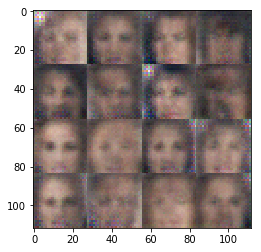

Epoch: 0 -- Step: 610 -- d_loss: 0.025085408240556717 -- g_loss: 11.573257446289062
Epoch: 0 -- Step: 620 -- d_loss: 0.22475704550743103 -- g_loss: 2.347269058227539
Epoch: 0 -- Step: 630 -- d_loss: 0.8320056200027466 -- g_loss: 0.9468396902084351
Epoch: 0 -- Step: 640 -- d_loss: 0.08229842036962509 -- g_loss: 10.26786994934082
Epoch: 0 -- Step: 650 -- d_loss: 0.2220553159713745 -- g_loss: 2.0585782527923584
Epoch: 0 -- Step: 660 -- d_loss: 0.03437761962413788 -- g_loss: 6.698307037353516
Epoch: 0 -- Step: 670 -- d_loss: 0.34403401613235474 -- g_loss: 1.6140066385269165
Epoch: 0 -- Step: 680 -- d_loss: 0.7415376305580139 -- g_loss: 0.9955461025238037
Epoch: 0 -- Step: 690 -- d_loss: 0.07741610705852509 -- g_loss: 12.133188247680664
Epoch: 0 -- Step: 700 -- d_loss: 0.01180320791900158 -- g_loss: 10.080947875976562


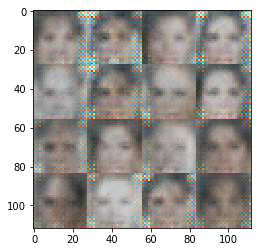

Epoch: 0 -- Step: 710 -- d_loss: 0.028915725648403168 -- g_loss: 6.951926231384277
Epoch: 0 -- Step: 720 -- d_loss: 0.02961934357881546 -- g_loss: 9.385424613952637
Epoch: 0 -- Step: 730 -- d_loss: 1.5368510484695435 -- g_loss: 4.474424839019775
Epoch: 0 -- Step: 740 -- d_loss: 1.10565984249115 -- g_loss: 0.8711267709732056
Epoch: 0 -- Step: 750 -- d_loss: 0.5506012439727783 -- g_loss: 1.4997475147247314
Epoch: 0 -- Step: 760 -- d_loss: 0.21012210845947266 -- g_loss: 7.024849891662598
Epoch: 0 -- Step: 770 -- d_loss: 0.8895856142044067 -- g_loss: 0.6779065132141113
Epoch: 0 -- Step: 780 -- d_loss: 0.016882114112377167 -- g_loss: 5.153511047363281
Epoch: 0 -- Step: 790 -- d_loss: 0.028467867523431778 -- g_loss: 13.233661651611328
Epoch: 0 -- Step: 800 -- d_loss: 0.40527355670928955 -- g_loss: 4.9291486740112305


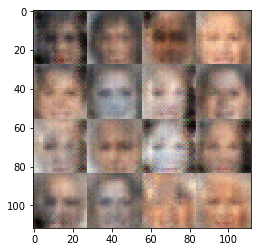

Epoch: 0 -- Step: 810 -- d_loss: 0.02825861983001232 -- g_loss: 9.44163703918457
Epoch: 0 -- Step: 820 -- d_loss: 0.5795177221298218 -- g_loss: 3.6058502197265625
Epoch: 0 -- Step: 830 -- d_loss: 0.02677215076982975 -- g_loss: 5.359992027282715
Epoch: 0 -- Step: 840 -- d_loss: 0.6018847227096558 -- g_loss: 1.1752874851226807
Epoch: 0 -- Step: 850 -- d_loss: 4.222273349761963 -- g_loss: 2.8860018253326416
Epoch: 0 -- Step: 860 -- d_loss: 0.0372328981757164 -- g_loss: 7.967791557312012
Epoch: 0 -- Step: 870 -- d_loss: 0.9973523616790771 -- g_loss: 0.6674382090568542
Epoch: 0 -- Step: 880 -- d_loss: 0.17749087512493134 -- g_loss: 2.496156692504883
Epoch: 0 -- Step: 890 -- d_loss: 0.03515654057264328 -- g_loss: 5.215573787689209
Epoch: 0 -- Step: 900 -- d_loss: 0.17127609252929688 -- g_loss: 4.994393348693848


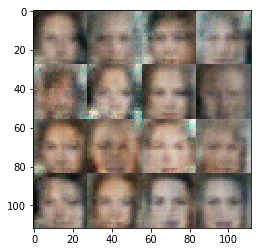

Epoch: 0 -- Step: 910 -- d_loss: 0.016669344156980515 -- g_loss: 7.852451801300049
Epoch: 0 -- Step: 920 -- d_loss: 0.05744130536913872 -- g_loss: 9.558969497680664
Epoch: 0 -- Step: 930 -- d_loss: 0.04837462678551674 -- g_loss: 4.686032295227051
Epoch: 0 -- Step: 940 -- d_loss: 0.10809571295976639 -- g_loss: 6.515450477600098
Epoch: 0 -- Step: 950 -- d_loss: 1.0509352684020996 -- g_loss: 0.9565585851669312
Epoch: 0 -- Step: 960 -- d_loss: 0.13447847962379456 -- g_loss: 5.058176517486572
Epoch: 0 -- Step: 970 -- d_loss: 0.038133591413497925 -- g_loss: 7.797834873199463
Epoch: 0 -- Step: 980 -- d_loss: 3.067323684692383 -- g_loss: 0.09094809740781784
Epoch: 0 -- Step: 990 -- d_loss: 0.07053346931934357 -- g_loss: 6.492067337036133
Epoch: 0 -- Step: 1000 -- d_loss: 0.06369520723819733 -- g_loss: 4.961629867553711


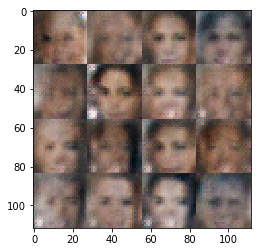

Epoch: 0 -- Step: 1010 -- d_loss: 0.09589807689189911 -- g_loss: 6.333683967590332
Epoch: 0 -- Step: 1020 -- d_loss: 0.10435547679662704 -- g_loss: 5.066709518432617
Epoch: 0 -- Step: 1030 -- d_loss: 0.0423203706741333 -- g_loss: 6.642643928527832
Epoch: 0 -- Step: 1040 -- d_loss: 0.054019976407289505 -- g_loss: 8.290865898132324
Epoch: 0 -- Step: 1050 -- d_loss: 0.030772950500249863 -- g_loss: 7.845332145690918
Epoch: 0 -- Step: 1060 -- d_loss: 0.3527708053588867 -- g_loss: 2.986461639404297
Epoch: 0 -- Step: 1070 -- d_loss: 0.025871407240629196 -- g_loss: 6.6610517501831055
Epoch: 0 -- Step: 1080 -- d_loss: 0.008727364242076874 -- g_loss: 6.860421180725098
Epoch: 0 -- Step: 1090 -- d_loss: 0.07810619473457336 -- g_loss: 6.399238109588623
Epoch: 0 -- Step: 1100 -- d_loss: 0.26394790410995483 -- g_loss: 2.720475673675537


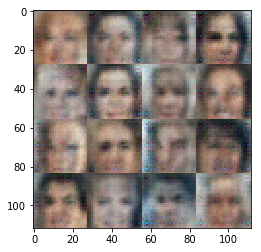

Epoch: 0 -- Step: 1110 -- d_loss: 0.12554872035980225 -- g_loss: 10.997392654418945
Epoch: 0 -- Step: 1120 -- d_loss: 0.03623484447598457 -- g_loss: 7.21465539932251
Epoch: 0 -- Step: 1130 -- d_loss: 1.0285354852676392 -- g_loss: 0.7464531660079956
Epoch: 0 -- Step: 1140 -- d_loss: 0.6382637023925781 -- g_loss: 1.0611428022384644
Epoch: 0 -- Step: 1150 -- d_loss: 0.19861619174480438 -- g_loss: 3.919969320297241
Epoch: 0 -- Step: 1160 -- d_loss: 1.3155392408370972 -- g_loss: 0.43554773926734924
Epoch: 0 -- Step: 1170 -- d_loss: 0.6406016945838928 -- g_loss: 1.0324406623840332
Epoch: 0 -- Step: 1180 -- d_loss: 0.3415529131889343 -- g_loss: 1.5076276063919067
Epoch: 0 -- Step: 1190 -- d_loss: 0.17781797051429749 -- g_loss: 5.995055675506592
Epoch: 0 -- Step: 1200 -- d_loss: 0.03685363382101059 -- g_loss: 8.559632301330566


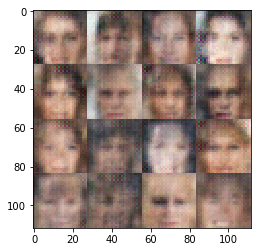

Epoch: 0 -- Step: 1210 -- d_loss: 0.01916501484811306 -- g_loss: 6.485882759094238
Epoch: 0 -- Step: 1220 -- d_loss: 0.04316786676645279 -- g_loss: 8.9588041305542
Epoch: 0 -- Step: 1230 -- d_loss: 1.233020305633545 -- g_loss: 1.0832068920135498
Epoch: 0 -- Step: 1240 -- d_loss: 0.24318990111351013 -- g_loss: 5.1919779777526855
Epoch: 0 -- Step: 1250 -- d_loss: 1.4125229120254517 -- g_loss: 0.4047388434410095
Epoch: 0 -- Step: 1260 -- d_loss: 0.12388406693935394 -- g_loss: 8.226478576660156
Epoch: 0 -- Step: 1270 -- d_loss: 0.38871675729751587 -- g_loss: 5.48797607421875
Epoch: 0 -- Step: 1280 -- d_loss: 0.01800721138715744 -- g_loss: 9.475316047668457
Epoch: 0 -- Step: 1290 -- d_loss: 0.04510998725891113 -- g_loss: 11.971311569213867
Epoch: 0 -- Step: 1300 -- d_loss: 0.035732124000787735 -- g_loss: 4.696151256561279


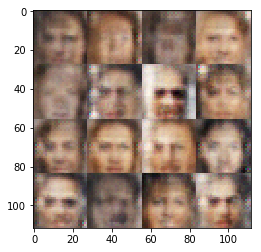

Epoch: 0 -- Step: 1310 -- d_loss: 0.010917426086962223 -- g_loss: 13.890562057495117
Epoch: 0 -- Step: 1320 -- d_loss: 0.2249956727027893 -- g_loss: 3.627974510192871
Epoch: 0 -- Step: 1330 -- d_loss: 0.006306903902441263 -- g_loss: 7.2722086906433105
Epoch: 0 -- Step: 1340 -- d_loss: 0.009564610198140144 -- g_loss: 11.874468803405762
Epoch: 0 -- Step: 1350 -- d_loss: 0.11910901218652725 -- g_loss: 5.880373001098633
Epoch: 0 -- Step: 1360 -- d_loss: 0.02350173331797123 -- g_loss: 11.302742004394531
Epoch: 0 -- Step: 1370 -- d_loss: 0.019995607435703278 -- g_loss: 7.780716896057129
Epoch: 0 -- Step: 1380 -- d_loss: 0.009239602833986282 -- g_loss: 10.298975944519043
Epoch: 0 -- Step: 1390 -- d_loss: 0.002957001095637679 -- g_loss: 11.80501651763916
Epoch: 0 -- Step: 1400 -- d_loss: 0.01239649299532175 -- g_loss: 8.38437557220459


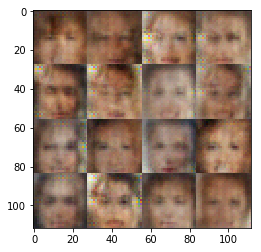

Epoch: 0 -- Step: 1410 -- d_loss: 0.05609206482768059 -- g_loss: 7.638589859008789
Epoch: 0 -- Step: 1420 -- d_loss: 0.13349784910678864 -- g_loss: 4.839136600494385
Epoch: 0 -- Step: 1430 -- d_loss: 0.06653531640768051 -- g_loss: 3.840808629989624
Epoch: 0 -- Step: 1440 -- d_loss: 0.06864098459482193 -- g_loss: 3.8533761501312256
Epoch: 0 -- Step: 1450 -- d_loss: 0.039679378271102905 -- g_loss: 7.234011650085449
Epoch: 0 -- Step: 1460 -- d_loss: 0.051059748977422714 -- g_loss: 5.1860432624816895
Epoch: 0 -- Step: 1470 -- d_loss: 0.2489617019891739 -- g_loss: 5.449211120605469
Epoch: 0 -- Step: 1480 -- d_loss: 0.0365995429456234 -- g_loss: 4.821734428405762
Epoch: 0 -- Step: 1490 -- d_loss: 2.0355119705200195 -- g_loss: 0.2184649109840393
Epoch: 0 -- Step: 1500 -- d_loss: 0.052082087844610214 -- g_loss: 9.18816089630127


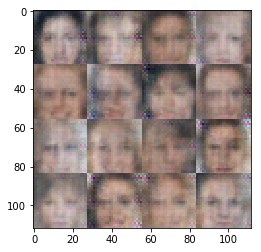

Epoch: 0 -- Step: 1510 -- d_loss: 0.4581916928291321 -- g_loss: 1.2921615839004517
Epoch: 0 -- Step: 1520 -- d_loss: 0.009559253230690956 -- g_loss: 11.780000686645508
Epoch: 0 -- Step: 1530 -- d_loss: 0.039179641753435135 -- g_loss: 8.136476516723633
Epoch: 0 -- Step: 1540 -- d_loss: 0.7224506139755249 -- g_loss: 1.804166316986084
Epoch: 0 -- Step: 1550 -- d_loss: 0.004752814769744873 -- g_loss: 10.581124305725098
Epoch: 0 -- Step: 1560 -- d_loss: 0.4459459185600281 -- g_loss: 1.219222068786621
Epoch: 0 -- Step: 1570 -- d_loss: 0.05127108842134476 -- g_loss: 9.041576385498047
Epoch: 0 -- Step: 1580 -- d_loss: 0.639740526676178 -- g_loss: 1.3886357545852661


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.